In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch.nn import BatchNorm1d
from torch.utils.data import Dataset
from torch_geometric.nn import GCNConv
from torch_geometric.nn import ChebConv
from torch_geometric.nn import global_add_pool, global_mean_pool
from torch_geometric.data import DataLoader
#from torch_scatter import scatter_mean
#import mol2graph
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

In [2]:
from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
# Pytorch and Pytorch Geometric
import torch
from torch_geometric.data import Data
from torch.utils.data import DataLoader

In [3]:
import os
import pandas as pd
import openpyxl

In [4]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
figures_dir = TOP + 'reports/figures/'
processed_dir= TOP+'data/processed/'

In [6]:
df = pd.read_excel(external_dir+'deduplicated_dtxsids.xlsx', sheet_name = 'TIMES_iv_out', index_col = [0])

In [7]:
df['parent'] = df['Chemical name'].fillna(method = 'ffill')

In [8]:
df['Chemical name'].nunique()
df['Parent'] = df['Chemical name'].apply(lambda x: 'Parent' if pd.notnull((x)) else np.nan)


In [9]:
df

,ID of metabolite,Level of generation,Predecessor ID,CAS,Chemical name,SMILES,Observed map/metabolite,Transformation name,Transformation No,Transformation ID,Transformation probability group,Transformation expert group,Transformation type,Transformation probability,Used probability,Quantity of metabolite,Total quantity of metabolite,Number of repetitions,parent,Parent
#,,,,,,,,,,,,,,,,,,,,
1,1,0,-,NaN,DTXSID8027292,CCCC[Sn](Cl)(Cl)CCCC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000006,0.000006,1,DTXSID8027292,Parent
1,2,1,1,NaN,NaN,CCCC[Sn](Cl)(Cl)CCCCO,NaN,Aliphatic C-Hydroxylation|Hydrocarbon Chain Me...,116.0,85.0,0.0,15.0,[phase I],0.95,0.2500,0.000003,0.000006,2,DTXSID8027292,NaN
1,6,2,2,NaN,NaN,OCCCC[Sn](Cl)(Cl)CCCCO,NaN,Aliphatic C-Hydroxylation|Hydrocarbon Chain Me...,116.0,85.0,0.0,15.0,[phase I],0.95,0.2533,0.000002,0.000003,2,DTXSID8027292,NaN
1,10,3,6,NaN,NaN,OCCCC[Sn](Cl)(Cl)CCCC=O,NaN,Aliphatic C-Oxidation|Primary Alcohol Aliphati...,132.0,97.0,0.0,21.0,[phase I],0.95,0.2568,0.016260,0.065040,4,DTXSID8027292,NaN
1,11,3,6,NaN,NaN,OCCCC[Sn](Cl)(Cl)CCCC=O,NaN,Aliphatic C-Oxidation|Primary Alcohol Aliphati...,132.0,97.0,0.0,21.0,[phase I],0.95,0.2568,0.016260,0.065040,4,DTXSID8027292,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,13,2,7,NaN,NaN,OC1C(O)C(O)C(C(O)=O)OC1OC(=O)CCC(O)=O,NaN,"O-Glucuronidation|Alcohol, Phenol, Carboxylic ...",340.0,222.0,0.0,2.0,[phase II],0.90,0.4950,0.246900,0.987500,4,DTXSID9074355,NaN
795,8,1,2,NaN,NaN,CC(O)=O,NaN,Beta-Oxidation|Straight-Chain Alkanecarboxylic...,101.0,72.0,0.0,39.0,[phase I],0.95,0.4988,0.049870,0.099750,2,DTXSID9074355,NaN
795,14,2,8,NaN,NaN,CC(=O)OC1C(O)C(O)C(O)C(C(O)=O)O1,NaN,"O-Glucuronidation|Alcohol, Phenol, Carboxylic ...",340.0,222.0,0.0,2.0,[phase II],0.90,0.9000,0.448900,0.897800,2,DTXSID9074355,NaN


In [10]:
def smi_inchi(x):
    mol = Chem.MolFromSmiles(x)
    clean_smi = Chem.MolToSmiles(mol, isomericSmiles=False)
    clean_mol = Chem.MolFromSmiles(clean_smi)
    inchi =     Chem.MolToInchi(clean_mol)
    inchi_key = Chem.InchiToInchiKey(inchi)
    return inchi_key

In [11]:
newlst = []

for i, group in df.groupby('#'):
    subset = group[['parent', 'Parent']]
    #print(i, subset)
    for x, y, z in zip(enumerate(range(0, len(subset['parent']))), subset['parent'], subset['Parent']):
        if z == 'Parent':
            newlst.append(y)
        elif z != 'Parent':
            newlst.append(y+'_m_'+str(x[0]))


In [12]:
len(newlst)

29542

In [13]:
df['ID'] = newlst


In [13]:
#df.to_csv(processed_dir+'df.csv')

In [15]:
inchi_keys = {}
errors = []
for k,v in zip(df['ID'], df['SMILES']):
    try:
        X = smi_inchi(v)
    except Exception as error:
        errors.append(error)
    else:
        inchi_keys[k] = X

[18:25:57] WARNING: Metal was disconnected; Proton(s) added/removed

[18:25:57] WARNING: Metal was disconnected; Proton(s) added/removed

[18:25:57] WARNING: Metal was disconnected; Proton(s) added/removed

[18:25:57] WARNING: Metal was disconnected; Proton(s) added/removed

[18:25:57] WARNING: Metal was disconnected; Proton(s) added/removed

[18:25:57] WARNING: Metal was disconnected; Omitted undefined stereo; Proton(s) added/removed

[18:25:57] WARNING: Metal was disconnected; Omitted undefined stereo; Proton(s) added/removed

[18:25:57] WARNING: Metal was disconnected; Omitted undefined stereo; Proton(s) added/removed

[18:25:57] WARNING: Metal was disconnected; Omitted undefined stereo; Proton(s) added/removed

[18:25:57] WARNING: Metal was disconnected; Omitted undefined stereo; Proton(s) added/removed

[18:25:57] WARNING: Metal was disconnected; Proton(s) added/removed

[18:25:57] WARNING: Metal was disconnected; Proton(s) added/removed

[18:25:57] WARNING: Metal was disconnected

In [16]:
len(errors)

677

In [17]:
len(inchi_keys)

28865

In [18]:
df_inchi = pd.DataFrame(inchi_keys.items(), columns = ['ID', 'INCHI_KEY'])

In [19]:
df2 = pd.merge(df, df_inchi, on = 'ID', how = 'left')

In [20]:
df2.head()

,ID of metabolite,Level of generation,Predecessor ID,CAS,Chemical name,SMILES,Observed map/metabolite,Transformation name,Transformation No,Transformation ID,...,Transformation type,Transformation probability,Used probability,Quantity of metabolite,Total quantity of metabolite,Number of repetitions,parent,Parent,ID,INCHI_KEY
0,1,0,-,NaN,DTXSID8027292,CCCC[Sn](Cl)(Cl)CCCC,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000006,0.000006,1,DTXSID8027292,Parent,DTXSID8027292,RJGHQTVXGKYATR-UHFFFAOYSA-L
1,2,1,1,NaN,NaN,CCCC[Sn](Cl)(Cl)CCCCO,NaN,Aliphatic C-Hydroxylation|Hydrocarbon Chain Me...,116.0,85.0,...,[phase I],0.95,0.2500,0.000003,0.000006,2,DTXSID8027292,NaN,DTXSID8027292_m_1,IETRGYIKDUGPQT-UHFFFAOYSA-L
2,6,2,2,NaN,NaN,OCCCC[Sn](Cl)(Cl)CCCCO,NaN,Aliphatic C-Hydroxylation|Hydrocarbon Chain Me...,116.0,85.0,...,[phase I],0.95,0.2533,0.000002,0.000003,2,DTXSID8027292,NaN,DTXSID8027292_m_2,QXUWUIHHWCNMPG-UHFFFAOYSA-L
3,10,3,6,NaN,NaN,OCCCC[Sn](Cl)(Cl)CCCC=O,NaN,Aliphatic C-Oxidation|Primary Alcohol Aliphati...,132.0,97.0,...,[phase I],0.95,0.2568,0.016260,0.065040,4,DTXSID8027292,NaN,DTXSID8027292_m_3,CWOITNIBJBIGIG-UHFFFAOYSA-L
4,11,3,6,NaN,NaN,OCCCC[Sn](Cl)(Cl)CCCC=O,NaN,Aliphatic C-Oxidation|Primary Alcohol Aliphati...,132.0,97.0,...,[phase I],0.95,0.2568,0.016260,0.065040,4,DTXSID8027292,NaN,DTXSID8027292_m_4,CWOITNIBJBIGIG-UHFFFAOYSA-L


In [21]:
df2[df2['INCHI_KEY'].isnull()]

,ID of metabolite,Level of generation,Predecessor ID,CAS,Chemical name,SMILES,Observed map/metabolite,Transformation name,Transformation No,Transformation ID,...,Transformation type,Transformation probability,Used probability,Quantity of metabolite,Total quantity of metabolite,Number of repetitions,parent,Parent,ID,INCHI_KEY
1145,1,0,-,NaN,DTXSID40893872,[O-].[Bi+3](.[O-]).[O-].[O-].[Bi+3](.[O-]).[O-...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.00000,1.0000,1,DTXSID40893872,Parent,DTXSID40893872,NaN
1324,1,0,-,NaN,DTXSID1020643,CCOP(=O)[O-].[Al+3](.[O-]P(=O)OCC).[O-]P(=O)OCC,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.00000,0.0000,1,DTXSID1020643,Parent,DTXSID1020643,NaN
2066,1,0,-,NaN,DTXSID701015566,O.O.O.O.O.O.O=N(=O)[O-].[Ce+3](.[O-]N(=O)=O).[...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.00000,1.0000,1,DTXSID701015566,Parent,DTXSID701015566,NaN
2468,1,0,-,NaN,DTXSID5051573,[O-2]1.[Y+3]2.[O-2].[Y+3].1.[O-2].2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.00000,1.0000,1,DTXSID5051573,Parent,DTXSID5051573,NaN
4232,1,0,-,NaN,DTXSID10893445,[N+].[Pt-2](.[N+])(Cl)(Cl)(Cl)(Cl)(Cl)Cl,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.00000,1.0000,1,DTXSID10893445,Parent,DTXSID10893445,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27231,148,2,7,NaN,NaN,CC(=O)[C-](C(C)=O).[Fe+3](.[C-](C(C)=O)C(C)=O)...,NaN,Aliphatic C-Oxidation|Primary Alcohol Aliphati...,132.0,97.0,...,[phase I],0.95,0.1439,0.02399,0.1439,6,DTXSID3051707,NaN,DTXSID3051707_m_167,NaN
27232,149,2,7,NaN,NaN,CC(=O)[C-](C(C)=O).[Fe+3](.[C-](C(C)=O)C(C)=O)...,NaN,"O-Glucuronidation|Alcohol, Phenol, Carboxylic ...",340.0,222.0,...,[phase II],0.90,0.1364,0.02273,0.1364,6,DTXSID3051707,NaN,DTXSID3051707_m_168,NaN
27369,1,0,-,NaN,DTXSID60886367,CCN(CC[n+]1(.[O-]C(C)=O)ccccc1)c1ccc(N=Nc2ccc(...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.00000,0.0000,1,DTXSID60886367,Parent,DTXSID60886367,NaN
27399,1,0,-,NaN,DTXSID7051476,CCCCCCCCCCCC[n+]1(.[Cl-])ccccc1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.00000,0.0000,1,DTXSID7051476,Parent,DTXSID7051476,NaN


In [22]:
df2['INCHI-KEY'] = df2[['INCHI_KEY', 'SMILES']].apply(lambda x: x[0] if pd.notnull((x[0])) else x[1], axis = 1)

In [23]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29542 entries, 0 to 29541
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ID of metabolite                  29542 non-null  int64  
 1   Level of generation               29542 non-null  int64  
 2   Predecessor ID                    29542 non-null  object 
 3   CAS                               0 non-null      float64
 4   Chemical name                     795 non-null    object 
 5   SMILES                            29542 non-null  object 
 6   Observed map/metabolite           2222 non-null   object 
 7   Transformation name               28747 non-null  object 
 8   Transformation No                 28747 non-null  float64
 9   Transformation ID                 28747 non-null  float64
 10  Transformation probability group  28747 non-null  float64
 11  Transformation expert group       28747 non-null  float64
 12  Tran

In [24]:
df4 = df2[['parent','ID of metabolite','Predecessor ID','INCHI-KEY','Transformation name']]

In [25]:
import networkx as nx

In [26]:
def createGraphs(csv):
    metabolites = []
    chemicals = []
    reactions = []
    rows = csv.to_dict(orient='records')
    for row in rows:
        metabolites.append(row['INCHI-KEY'])
        chemicals.append(row['parent'])
        reactions.append(row['Transformation name'])

    chemicals = np.unique(chemicals)
    metabolites = np.unique(metabolites)
    reactions = np.unique(reactions)

    frames = []
    for chemical in chemicals:
        newFrame = pd.DataFrame()
        name = chemical
        for row in rows:
            if row['parent'] == name:
                newFrame = pd.concat([newFrame, pd.DataFrame([row])],ignore_index=True)
        frames.append(newFrame)

    graphs = []
    for chemical in frames:
        newGraph = nx.DiGraph()
        newGraph.name = chemical['parent'][0]
        nodeID = 0
        for i in range(len(chemical)):
            if i == 0:
                newGraph.add_node(nodeID,smile=chemical['INCHI-KEY'][i])
                nodeID += 1
            else:
                newGraph.add_node(nodeID,smile=chemical['INCHI-KEY'][i])
                newGraph.add_edge((int(chemical['Predecessor ID'][i])-1),int(nodeID),reaction=chemical['Transformation name'][i])
                nodeID += 1
        graphs.append(newGraph)
    print(str(len(graphs)) + ' metabolic graph objects created.')
    print(str(len(metabolites)) + ' unique metabolites generated in predictions.')
    print(str(len(reactions)) + ' unique reactions generating metabolites in predictions.')
    return graphs,metabolites 

In [27]:
a,b = createGraphs(df4)

795 metabolic graph objects created.
9461 unique metabolites generated in predictions.
232 unique reactions generating metabolites in predictions.


In [28]:
graphNames = []
for graph in a:
    graphNames.append(graph.name)


In [29]:
import grakel
from grakel import Graph
from grakel import kernels 

In [30]:
gkGraphs = grakel.graph_from_networkx(a,node_labels_tag='smile')

In [31]:
WL = kernels.WeisfeilerLehman(normalize=True)

In [32]:
kernelScores = pd.DataFrame(WL.fit_transform(gkGraphs))
labels = list(np.arange(0,len(graphNames),1))
index = dict(zip(labels,graphNames))
kernelScores = kernelScores.rename(index=index)
kernelScores = kernelScores.rename(columns=index)

In [33]:
import seaborn as sns

<Axes: >

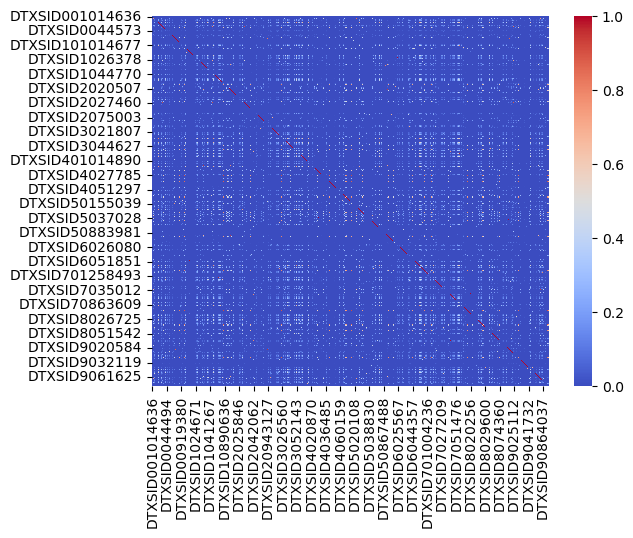

In [34]:
sns.heatmap(kernelScores, cmap = 'coolwarm')

In [35]:
kernelScores.to_csv(processed_dir+'WL_TIMES_300623.csv')

In [36]:
df2['Transformation name'].nunique()

231

In [37]:
df2

,ID of metabolite,Level of generation,Predecessor ID,CAS,Chemical name,SMILES,Observed map/metabolite,Transformation name,Transformation No,Transformation ID,...,Transformation probability,Used probability,Quantity of metabolite,Total quantity of metabolite,Number of repetitions,parent,Parent,ID,INCHI_KEY,INCHI-KEY
0,1,0,-,NaN,DTXSID8027292,CCCC[Sn](Cl)(Cl)CCCC,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000006,0.000006,1,DTXSID8027292,Parent,DTXSID8027292,RJGHQTVXGKYATR-UHFFFAOYSA-L,RJGHQTVXGKYATR-UHFFFAOYSA-L
1,2,1,1,NaN,NaN,CCCC[Sn](Cl)(Cl)CCCCO,NaN,Aliphatic C-Hydroxylation|Hydrocarbon Chain Me...,116.0,85.0,...,0.95,0.2500,0.000003,0.000006,2,DTXSID8027292,NaN,DTXSID8027292_m_1,IETRGYIKDUGPQT-UHFFFAOYSA-L,IETRGYIKDUGPQT-UHFFFAOYSA-L
2,6,2,2,NaN,NaN,OCCCC[Sn](Cl)(Cl)CCCCO,NaN,Aliphatic C-Hydroxylation|Hydrocarbon Chain Me...,116.0,85.0,...,0.95,0.2533,0.000002,0.000003,2,DTXSID8027292,NaN,DTXSID8027292_m_2,QXUWUIHHWCNMPG-UHFFFAOYSA-L,QXUWUIHHWCNMPG-UHFFFAOYSA-L
3,10,3,6,NaN,NaN,OCCCC[Sn](Cl)(Cl)CCCC=O,NaN,Aliphatic C-Oxidation|Primary Alcohol Aliphati...,132.0,97.0,...,0.95,0.2568,0.016260,0.065040,4,DTXSID8027292,NaN,DTXSID8027292_m_3,CWOITNIBJBIGIG-UHFFFAOYSA-L,CWOITNIBJBIGIG-UHFFFAOYSA-L
4,11,3,6,NaN,NaN,OCCCC[Sn](Cl)(Cl)CCCC=O,NaN,Aliphatic C-Oxidation|Primary Alcohol Aliphati...,132.0,97.0,...,0.95,0.2568,0.016260,0.065040,4,DTXSID8027292,NaN,DTXSID8027292_m_4,CWOITNIBJBIGIG-UHFFFAOYSA-L,CWOITNIBJBIGIG-UHFFFAOYSA-L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29537,13,2,7,NaN,NaN,OC1C(O)C(O)C(C(O)=O)OC1OC(=O)CCC(O)=O,NaN,"O-Glucuronidation|Alcohol, Phenol, Carboxylic ...",340.0,222.0,...,0.90,0.4950,0.246900,0.987500,4,DTXSID9074355,NaN,DTXSID9074355_m_9,JBELGDHYGYAFBA-UHFFFAOYSA-N,JBELGDHYGYAFBA-UHFFFAOYSA-N
29538,8,1,2,NaN,NaN,CC(O)=O,NaN,Beta-Oxidation|Straight-Chain Alkanecarboxylic...,101.0,72.0,...,0.95,0.4988,0.049870,0.099750,2,DTXSID9074355,NaN,DTXSID9074355_m_10,QTBSBXVTEAMEQO-UHFFFAOYSA-N,QTBSBXVTEAMEQO-UHFFFAOYSA-N
29539,14,2,8,NaN,NaN,CC(=O)OC1C(O)C(O)C(O)C(C(O)=O)O1,NaN,"O-Glucuronidation|Alcohol, Phenol, Carboxylic ...",340.0,222.0,...,0.90,0.9000,0.448900,0.897800,2,DTXSID9074355,NaN,DTXSID9074355_m_11,KKQGLALOFAYFGV-UHFFFAOYSA-N,KKQGLALOFAYFGV-UHFFFAOYSA-N
29540,3,0,1,NaN,NaN,[Li]O,NaN,External Hydrolysis,716.0,10001.0,...,1.00,1.0000,1.000000,2.000000,2,DTXSID9074355,NaN,DTXSID9074355_m_12,WMFOQBRAJBCJND-UHFFFAOYSA-M,WMFOQBRAJBCJND-UHFFFAOYSA-M


In [38]:
pd.crosstab(df2['parent'], df2['Transformation name'] )

Transformation name,Glutathione Conjugation|Glutathione-Derived Conjugation|Haloacetic Acid Glutathione-Derived Conjugation,Isomerization|Cycloisomerization|Gamma-Hydroxy Alkanenitrile Cycloisomerization,Acetylation|Arene Sulfonamide N-Acetylation,Acetylation|N-Hydroxylamine O-Acetylation|Aromatic N-Hydroxylamine O-Acetylation,Aliphatic C-Hydroxylation|(Omega-1) Oxidation,"Aliphatic C-Hydroxylation|1,1,1-Trihaloethane Aliphatic C-Hydroxylation",Aliphatic C-Hydroxylation|Alkanenitrile Aliphatic Alpha-C-Hydroxylation,Aliphatic C-Hydroxylation|Alkanoic Acid Aliphatic C-Hydroxylation|2-Alkylalkanoic Acid Aliphatic C-Hydroxylation,Aliphatic C-Hydroxylation|Allylic Aliphatic C-Hydroxylation,Aliphatic C-Hydroxylation|Aryl Substituted Alkane Aliphatic C-Hydroxylation|Aryl Substituted Branched Alkane Aliphatic C-Hydroxylation,...,Sulfation|N-Acetylation and Sulfation|Halogenated o-Aminophenol Derivative N-Acetylation and Sulfation,Sulfation|N-Hydroxylamine Sulfation,Sulfation|Phenol Sulfation,Sulfoxide Reduction|Organic Sulfoxide Reduction,Tautomerization|Iminol Tautomerization,Tautomerization|Oxo-Enol Tautomerization,Tautomerization|Thiourea or Thionamide Derivative Tautomerization,Thiolation|Formamidine Derivative Thiolation,Thiolation|Haloarene Thiolation,Thiomethylation|Haloarene Thiomethylation
parent,,,,,,,,,,,,,,,,,,,,,
DTXSID001014636,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID001108700,0,0,0,0,1,0,0,0,0,0,...,0,0,7,0,0,0,0,0,2,2
DTXSID0020232,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,7,0,0,9,0,0
DTXSID00204642,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID0020606,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DTXSID90884497,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID90889341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID90890230,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
mydict = {}
for i, group in df2.groupby('parent'):
    mydict[i] = len(group['ID'])

In [41]:
list({k:v for k,v in mydict.items() if v ==1}.keys())

['DTXSID0020078',
 'DTXSID0020941',
 'DTXSID0025816',
 'DTXSID0026252',
 'DTXSID0026701',
 'DTXSID0049816',
 'DTXSID0064333',
 'DTXSID00858866',
 'DTXSID00889615',
 'DTXSID00893439',
 'DTXSID1020194',
 'DTXSID1021291',
 'DTXSID1021451',
 'DTXSID1023784',
 'DTXSID1026039',
 'DTXSID1029673',
 'DTXSID1029677',
 'DTXSID1029704',
 'DTXSID1029706',
 'DTXSID1039719',
 'DTXSID1042108',
 'DTXSID10883144',
 'DTXSID10890636',
 'DTXSID10893445',
 'DTXSID10894154',
 'DTXSID2020630',
 'DTXSID2020711',
 'DTXSID2024169',
 'DTXSID2025424',
 'DTXSID2025509',
 'DTXSID2029668',
 'DTXSID2034839',
 'DTXSID2035223',
 'DTXSID2040315',
 'DTXSID2041125',
 'DTXSID2041676',
 'DTXSID2042436',
 'DTXSID2047482',
 'DTXSID20889617',
 'DTXSID20892161',
 'DTXSID20892186',
 'DTXSID20923782',
 'DTXSID3021352',
 'DTXSID3036446',
 'DTXSID3040435',
 'DTXSID3044592',
 'DTXSID3047003',
 'DTXSID3052484',
 'DTXSID3052486',
 'DTXSID3063754',
 'DTXSID30858819',
 'DTXSID30883121',
 'DTXSID30890512',
 'DTXSID30890517',
 'DTXSID30897

In [42]:
for index in df2[df2['Chemical name'].isin(list({k:v for k,v in mydict.items() if v ==1}.keys()))].index:
    df2.loc[index, 'Transformation name'] = 'no_metabolism'

In [43]:
df2[df2['Chemical name'].isin(list({k:v for k,v in mydict.items() if v ==1}.keys()))]

,ID of metabolite,Level of generation,Predecessor ID,CAS,Chemical name,SMILES,Observed map/metabolite,Transformation name,Transformation No,Transformation ID,...,Transformation probability,Used probability,Quantity of metabolite,Total quantity of metabolite,Number of repetitions,parent,Parent,ID,INCHI_KEY,INCHI-KEY
447,1,0,-,NaN,DTXSID2020630,[F-].[Na+],NaN,no_metabolism,NaN,NaN,...,NaN,NaN,1.0,1.0,1,DTXSID2020630,Parent,DTXSID2020630,PUZPDOWCWNUUKD-UHFFFAOYSA-M,PUZPDOWCWNUUKD-UHFFFAOYSA-M
1106,1,0,-,NaN,DTXSID6034479,O=S1(=O)[O-].[Cu+2].[O-]1,NaN,no_metabolism,NaN,NaN,...,NaN,NaN,1.0,1.0,1,DTXSID6034479,Parent,DTXSID6034479,ARUVKPQLZAKDPS-UHFFFAOYSA-L,ARUVKPQLZAKDPS-UHFFFAOYSA-L
1107,1,0,-,NaN,DTXSID5029683,OS(O)(=O)=O,NaN,no_metabolism,NaN,NaN,...,NaN,NaN,1.0,1.0,1,DTXSID5029683,Parent,DTXSID5029683,QAOWNCQODCNURD-UHFFFAOYSA-N,QAOWNCQODCNURD-UHFFFAOYSA-N
1123,1,0,-,NaN,DTXSID2020711,Cl,NaN,no_metabolism,NaN,NaN,...,NaN,NaN,1.0,1.0,1,DTXSID2020711,Parent,DTXSID2020711,VEXZGXHMUGYJMC-UHFFFAOYSA-N,VEXZGXHMUGYJMC-UHFFFAOYSA-N
1145,1,0,-,NaN,DTXSID40893872,[O-].[Bi+3](.[O-]).[O-].[O-].[Bi+3](.[O-]).[O-...,NaN,no_metabolism,NaN,NaN,...,NaN,NaN,1.0,1.0,1,DTXSID40893872,Parent,DTXSID40893872,NaN,[O-].[Bi+3](.[O-]).[O-].[O-].[Bi+3](.[O-]).[O-...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28533,1,0,-,NaN,DTXSID50884498,[O-2]1.[Pr+3]2.[O-2].[Pr+3].1.[O-2].2,NaN,no_metabolism,NaN,NaN,...,NaN,NaN,1.0,1.0,1,DTXSID50884498,Parent,DTXSID50884498,NaN,[O-2]1.[Pr+3]2.[O-2].[Pr+3].1.[O-2].2
28783,1,0,-,NaN,DTXSID2034839,O=[Mn](=O)(=O)[O-].[K+],NaN,no_metabolism,NaN,NaN,...,NaN,NaN,1.0,1.0,1,DTXSID2034839,Parent,DTXSID2034839,VZJVWSHVAAUDKD-UHFFFAOYSA-N,VZJVWSHVAAUDKD-UHFFFAOYSA-N
29284,1,0,-,NaN,DTXSID00893439,[Ce+4].[N+].[O-]N(=O)=O.[N+].[O-]N(=O)=O.ON(=O...,NaN,no_metabolism,NaN,NaN,...,NaN,NaN,1.0,1.0,1,DTXSID00893439,Parent,DTXSID00893439,SGMVKVFHPCBSDC-UHFFFAOYSA-N,SGMVKVFHPCBSDC-UHFFFAOYSA-N
29359,1,0,-,NaN,DTXSID60894063,[N+].[I-],NaN,no_metabolism,NaN,NaN,...,NaN,NaN,1.0,1.0,1,DTXSID60894063,Parent,DTXSID60894063,BIHGDLZLEQUUEH-UHFFFAOYSA-M,BIHGDLZLEQUUEH-UHFFFAOYSA-M


In [44]:
df_metab = pd.crosstab(df2['parent'], df2['Transformation name'] )

In [45]:
from scipy.spatial.distance import pdist, squareform

In [46]:
def distance_matrix(df):
    '''
    Function to create a pairwise square distance matrix using the Jaccard index
    '''
    D_mgrn = pd.DataFrame(squareform(pdist(df, 'jaccard')), columns = df.index, index = df.index)

    return D_mgrn

In [47]:
S_metab = 1-distance_matrix(df_metab)

In [48]:
S_metab.to_csv(processed_dir+'Stransformations_300623.csv')

In [49]:
df_metabs = pd.crosstab(df2['parent'], df2['INCHI-KEY'] )

In [50]:
S_metabs = 1-distance_matrix(df_metabs)

<Axes: xlabel='parent', ylabel='parent'>

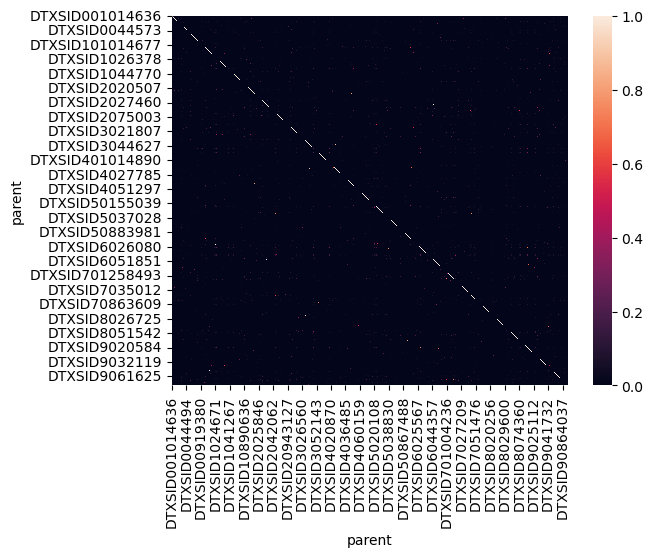

In [51]:
sns.heatmap(S_metabs)

In [52]:
S_metabs.to_csv(processed_dir+'Smetabolites_300623.csv')